# ASTR 598 HW1
# Hayden Smotherman, Chris Suberlak, Bryce Bolin, Winnie Wang

In [2]:
import astropy.visualization as vis
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import os
import numpy as np
import urllib.request
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table
from astropy.table import hstack
from astropy.table import vstack
from astropy import wcs
from itertools import product
from scipy.stats import binned_statistic as bs

Workflow : 
    
  1) from  http://das.sdss.org/va/stripe_82_variability/SDSS_82_public/
download eight HLC*fits.gz files
  
  2) For each HLC file, and separately for stars and galaxies (use MEAN_OBJECT_TYPE > 5 to classify stars), make a 3-panel plot with one panel showing the Hess (counts) r vs. g-i diagram and another two using isoplets for counts and color scheme to show the median RA and Dec proper motions.

  3) Make a few other interesting and judiciously chosen plots!


In [3]:
# https://github.com/astroML/astroML/blob/master/astroML/datasets/sdss_sspp.py
# fetch_sdds_ssp() is there 

catalogs = ['HLC.RA_20_to_21.fits.gz',
'HLC.RA_21_to_22.fits.gz',
'HLC.RA_22_to_23.fits.gz',
'HLC.RA_23_to_24.fits.gz',
'HLC.RA_00_to_01.fits.gz',
'HLC.RA_01_to_02.fits.gz',
'HLC.RA_02_to_03.fits.gz',
'HLC.RA_03_to_04.fits.gz']
for cat_name in catalogs : 
    if cat_name not in os.listdir():
        print('Downloading ...', cat_name)# if not, download it ...
        url = 'http://das.sdss.org/va/stripe_82_variability/SDSS_82_public/' + cat_name
        urllib.request.urlretrieve(url, cat_name)

In [4]:
def ReadTable(name):
    hlc_fits = fits.open(name)
    hlc_table = Table(hlc_fits[1].data)
    return hlc_table

# open the files with astropy ...
hlc_hdu = fits.open(catalogs[0])

# read the data into Table: 
hlc_table = Table(hlc_hdu[1].data)

In [5]:
# display the fits info :
hlc_hdu.info()

Filename: HLC.RA_20_to_21.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU    171   390491R x 77C   ['46A', '24A', '5I', '5E', '5E', '5E', '5E', '5E', '5E', '5E', '5E', '5I', '5I', '5E', '5E', '5E', '5E', '5E', '5E', '5E', '5E', '5E', '5E', '5E', '5E', '5E', '5E', '5E', '5E', '5E', '5E', 'D', 'E', 'E', '5E', 'D', 'E', 'E', 'E', 'D', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'D', 'E', 'E', 'E', 'D', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'D', 'D', 'I', 'I', 'E', 'E', 'D', 'E', 'E', 'D', '5E', '5E', '5E', '5E', '5E', '5E', '5E', '5E']   


In [7]:
# display the header of the table
#hlc_hdu[1].header

In [9]:
# so it looks like each row is a light curve for an object,
# and there are 390 491 objects...
#hlc_table[0]['N_GOOD_EPOCHS']

In [10]:
# show all column names : 
np.ravel(hlc_table.colnames)

array(['LC_NAME', 'IAU_NAME', 'N_GOOD_EPOCHS', 'MEAN_PSFMAG',
       'MEAN_PSFMAG_ERR', 'MEAN_EXPMAG', 'MEAN_EXPMAG_ERR', 'RMS_PSFMAG',
       'RMS_EXPMAG', 'CHISQ_PSFMAG', 'CHISQ_EXPMAG',
       'N_GOOD_EPOCHS_PSF_CLIP', 'N_GOOD_EPOCHS_EXP_CLIP',
       'MEAN_PSFMAG_CLIP', 'MEAN_PSFMAG_ERR_CLIP', 'MEAN_EXPMAG_CLIP',
       'MEAN_EXPMAG_ERR_CLIP', 'RMS_PSFMAG_CLIP', 'RMS_EXPMAG_CLIP',
       'CHISQ_PSFMAG_CLIP', 'CHISQ_EXPMAG_CLIP', 'MEAN_PSFMAG_ITER',
       'MEAN_PSFMAG_ERR_ITER', 'MEAN_EXPMAG_ITER', 'MEAN_EXPMAG_ERR_ITER',
       'PERCENTILE_05_PSF', 'PERCENTILE_50_PSF', 'PERCENTILE_95_PSF',
       'PERCENTILE_05_EXP', 'PERCENTILE_50_EXP', 'PERCENTILE_95_EXP',
       'TIME_SPAN', 'MEAN_OBJECT_TYPE', 'MEAN_CHILD', 'REDDENING',
       'RA_MEAN', 'RA_MEAN_ERR', 'RA_PM', 'RA_PM_ERR', 'RA_MEAN_CLIP',
       'RA_MEAN_ERR_CLIP', 'RA_PM_CLIP', 'RA_PM_ERR_CLIP', 'RA_CHISQ_CON',
       'RA_CHISQ_CON_CLIP', 'RA_CHISQ_LIN', 'RA_CHISQ_LIN_CLIP',
       'DEC_MEAN', 'DEC_MEAN_ERR', 'DEC_PM', 'DEC_

(array([  52087.,    7348.,    5057.,    5417.,    3829.,    6515.,
           8744.,   12228.,   26884.,  262382.]),
 array([ 3. ,  3.3,  3.6,  3.9,  4.2,  4.5,  4.8,  5.1,  5.4,  5.7,  6. ]),
 <a list of 10 Patch objects>)

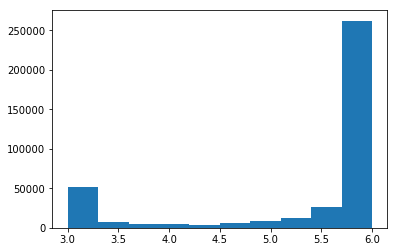

In [11]:
# If we are to use MEAN_OBJECT_TYPE   , lets plot the histogram ... 
%matplotlib inline
plt.hist(hlc_table['MEAN_OBJECT_TYPE'].data)

(array([ 44622.,  42614.,  40920.,  40934.,  38797.,  38014.,  37227.,
         36445.,  36154.,  34764.]),
 array([ 310.5000112 ,  310.95000987,  311.40000854,  311.85000721,
         312.30000588,  312.75000455,  313.20000322,  313.65000189,
         314.10000056,  314.54999923,  314.9999979 ]),
 <a list of 10 Patch objects>)

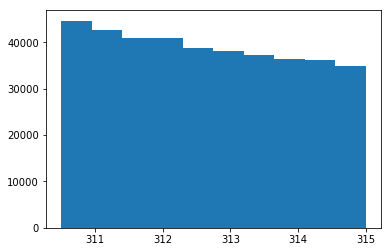

In [12]:
plt.hist(hlc_table['RA_MEAN'].data)

(array([ 38065.,  39149.,  38231.,  38605.,  38903.,  38790.,  39701.,
         39361.,  39469.,  40217.]),
 array([ -1.25999744e+00,  -1.00799887e+00,  -7.56000310e-01,
         -5.04001745e-01,  -2.52003181e-01,  -4.61638746e-06,
          2.51993948e-01,   5.03992512e-01,   7.55991077e-01,
          1.00798964e+00,   1.25998821e+00]),
 <a list of 10 Patch objects>)

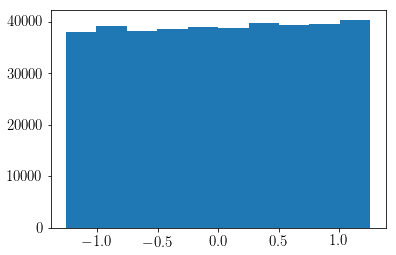

In [124]:
plt.hist(hlc_table['DEC_MEAN'].data)

In [14]:
# so the table 'squashed'  all five filters into 5 measurements per row... Unpack these:
# I assume these are standard u,g,r,i,z 

mean_psfmag = Table(hlc_table['MEAN_PSFMAG'], names=('u', 'g', 'r', 'i','z'))
mean_psfmag_err = Table(hlc_table['MEAN_PSFMAG_ERR'], names=('u', 'g', 'r', 'i','z'))

# select only S/N > 5 
SN = {}
for f in mean_psfmag.colnames : 
    SN[f] = mean_psfmag[f] / mean_psfmag_err[f]

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


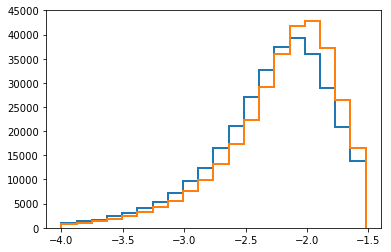

In [17]:
ra_pm = hlc_table['RA_PM_CLIP']
dec_pm = hlc_table['DEC_PM_CLIP']
for quantity in [ra_pm, dec_pm] : 
    mask =(1e-4<np.abs(quantity)) * (np.abs(quantity)<0.03)
    plt.hist(np.log10(np.abs(quantity[mask])), 
             lw=2, bins=20, histtype='step')

In [128]:
np.ravel(hlc_table.colnames)

array(['LC_NAME', 'IAU_NAME', 'N_GOOD_EPOCHS', 'MEAN_PSFMAG',
       'MEAN_PSFMAG_ERR', 'MEAN_EXPMAG', 'MEAN_EXPMAG_ERR', 'RMS_PSFMAG',
       'RMS_EXPMAG', 'CHISQ_PSFMAG', 'CHISQ_EXPMAG',
       'N_GOOD_EPOCHS_PSF_CLIP', 'N_GOOD_EPOCHS_EXP_CLIP',
       'MEAN_PSFMAG_CLIP', 'MEAN_PSFMAG_ERR_CLIP', 'MEAN_EXPMAG_CLIP',
       'MEAN_EXPMAG_ERR_CLIP', 'RMS_PSFMAG_CLIP', 'RMS_EXPMAG_CLIP',
       'CHISQ_PSFMAG_CLIP', 'CHISQ_EXPMAG_CLIP', 'MEAN_PSFMAG_ITER',
       'MEAN_PSFMAG_ERR_ITER', 'MEAN_EXPMAG_ITER', 'MEAN_EXPMAG_ERR_ITER',
       'PERCENTILE_05_PSF', 'PERCENTILE_50_PSF', 'PERCENTILE_95_PSF',
       'PERCENTILE_05_EXP', 'PERCENTILE_50_EXP', 'PERCENTILE_95_EXP',
       'TIME_SPAN', 'MEAN_OBJECT_TYPE', 'MEAN_CHILD', 'REDDENING',
       'RA_MEAN', 'RA_MEAN_ERR', 'RA_PM', 'RA_PM_ERR', 'RA_MEAN_CLIP',
       'RA_MEAN_ERR_CLIP', 'RA_PM_CLIP', 'RA_PM_ERR_CLIP', 'RA_CHISQ_CON',
       'RA_CHISQ_CON_CLIP', 'RA_CHISQ_LIN', 'RA_CHISQ_LIN_CLIP',
       'DEC_MEAN', 'DEC_MEAN_ERR', 'DEC_PM', 'DEC_

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:929: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, oper)(other)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:122: RuntimeWarning: divide by zero encountered in log10


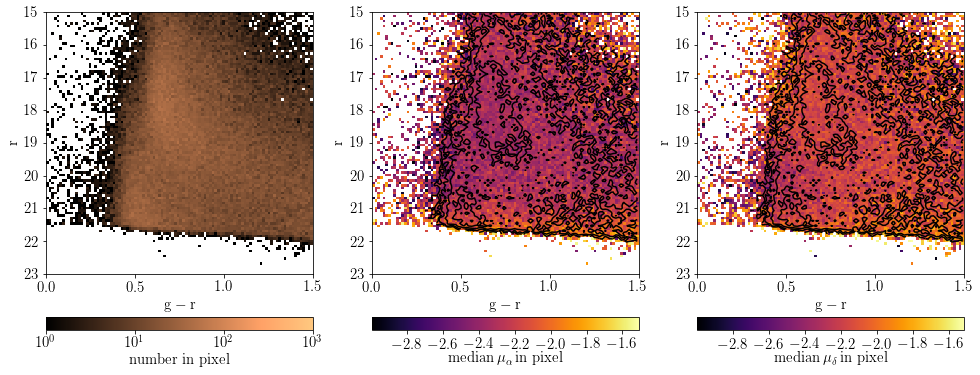

In [27]:
from scipy.stats import binned_statistic_2d as bs2d 
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=15, usetex=True)

# select only high signal to noise :
mSN = (SN['g'] > 5) * ( SN['r'] > 5) * ( SN['i'] > 5 )

# select stars 
mStars = hlc_table['MEAN_OBJECT_TYPE'].data > 5 

# select reasonable color range ...
gi = mean_psfmag['g'] - mean_psfmag['i']
r = mean_psfmag['r']

m_gi =  (0<gi) * (gi<1.5)
m_r = (15 < r) * (r < 23 )

# select the PM range that makes sense..
pm_ra = np.abs(hlc_table['RA_PM_CLIP'].data)
pm_dec = np.abs(hlc_table['DEC_PM_CLIP'].data)
lower_cutoff = 10**(-3.0)
upper_cutoff = 10**(-1.5)
m_pm_ra = (lower_cutoff<pm_ra)*(pm_ra < upper_cutoff)
m_pm_dec =  (lower_cutoff<pm_dec)*(pm_dec<upper_cutoff)

# combine the masks ...
m = mSN * mStars * m_gi * m_r * m_pm_ra * m_pm_dec

# plot 
#fig,ax = plt.subplots(1,3,figsize=(18,6))
x = mean_psfmag['g'][m] - mean_psfmag['i'][m]
y = mean_psfmag['r'][m]
ra = pm_ra[m]
dec =  pm_dec[m]

# use binned_statistic2d  ....
N = bs2d(x,y,x, 'count', bins=100)
RA_med = bs2d(x,y,ra,statistic='median', bins=100)
DEC_med = bs2d(x,y,dec,statistic='median', bins=100)

# Define custom colormaps: Set pixels with no sources to white
cmap = plt.cm.copper
cmap.set_bad('w', 1.)

cmap_multicolor = plt.cm.inferno
cmap_multicolor.set_bad('w', 1.)

# Create figure and subplots
fig = plt.figure(figsize=(15, 6))
fig.subplots_adjust(wspace=0.22, left=0.1, right=0.95,
                    bottom=0.12, top=0.95)

# set colorbar padding
cbar_padding = 0.12

#--------------------
# First axes:
ax = plt.subplot(131) # , xticks=[4000, 5000, 6000, 7000, 8000])
plt.imshow(np.log10(N.statistic.T), origin='lower',
           extent=[N.x_edge[0], N.x_edge[-1], N.y_edge[0], N.y_edge[-1]],
           aspect='auto', interpolation='nearest', cmap=cmap)
plt.xlim(0,1.5)
plt.ylim(15,23)
cb = plt.colorbar(ticks=[0, 1, 2, 3], pad=cbar_padding ,
                  format=r'$10^{%i}$', orientation='horizontal')
cb.set_label(r'$\mathrm{number\ in\ pixel}$')
plt.clim(0, 3)
plt.xlabel(r'$\mathrm{g-r}$')
plt.ylabel(r'$\mathrm{r}$')
plt.gca().invert_yaxis()


#--------------------
# Second axes:
ax = plt.subplot(132)

# define tick location given the PM range ...
#pm_ticks = [-0.04,-0.02,0,0.02,0.04]
#pm_ticks = np.log10(np.array([-0.04,-0.02,0,0.02,0.04]))

# color by median RA 
plt.imshow(np.log10(RA_med.statistic.T), origin='lower',
           extent=[RA_med.x_edge[0], RA_med.x_edge[-1], 
                   RA_med.y_edge[0], RA_med.y_edge[-1]],
           aspect='auto', interpolation='nearest', 
           cmap=cmap_multicolor )
#ticks=np.arange(-2.5, 1, 1)
cb = plt.colorbar(pad=cbar_padding , orientation='horizontal')
cb.set_label(r'$\mathrm{median}\, \mu_{\alpha}\, \mathrm{in\ pixel} $')
#plt.clim(-2.5, 0.5)

# plot the contour of color counts 
levels = np.linspace(0, np.log10(N.statistic.max()), 7)[2:]
plt.contour(np.log10(N.statistic.T), levels, colors='k',
            extent=[N.x_edge[0], N.x_edge[-1], N.y_edge[0], N.y_edge[-1]],
           origin='lower')

plt.xlim(0,1.5)
plt.ylim(15,23)
plt.xlabel(r'$\mathrm{g-r}$')
plt.ylabel(r'$\mathrm{r}$')
plt.gca().invert_yaxis()

#--------------------
# Third axes:

ax = plt.subplot(133)

# color by median DEC
plt.imshow(np.log10(DEC_med.statistic.T), origin='lower',
           extent=[DEC_med.x_edge[0], DEC_med.x_edge[-1], 
                   DEC_med.y_edge[0], DEC_med.y_edge[-1]],
           aspect='auto', interpolation='nearest', 
           cmap=cmap_multicolor )
#ticks=np.arange(-2.5, 1, 1)
cb = plt.colorbar(  pad=cbar_padding , orientation='horizontal')
cb.set_label(r'$\mathrm{median}\, \mu_{\delta}\, \mathrm{in\ pixel} $')
#plt.clim(-2.5, 0.5)

# plot the contour of color counts 
levels = np.linspace(0, np.log10(N.statistic.max()), 7)[2:]
plt.contour(np.log10(N.statistic.T), levels, colors='k',
            extent=[N.x_edge[0], N.x_edge[-1], N.y_edge[0], N.y_edge[-1]],
           origin='lower')

plt.xlim(0,1.5)
plt.ylim(15,23)
plt.xlabel(r'$\mathrm{g-r}$')
plt.ylabel(r'$\mathrm{r}$')
plt.gca().invert_yaxis()

plt.savefig(str(catalogs[0])+'.png', bbox_inches='tight')

Ok , we can definitely see two main sequences here in RA 20 to 21 

The Light-Motion-Curve Catalogue (LMCC) covers Stripe 82 from RA = 20.7h to 3.3h and from Dec. = -1.26 deg to 1.26 deg, which equates to ~249 square degrees. This Stripe has been repeatedly monitored in the u, g, r, i and z bands over a seven-year baseline. The resulting catalogue contains almost 4 million light-motion curves of stellar objects and galaxies. Along with the LMCC, we supply a number of IDL plotting tools to aid in the visualisation of the light-motion-curves (see below).

We also provide what we refer to as the Higher-Level Catalogue (HLC) in 8 separate gzipped binary fits files. This catalogue supplies 235 derived quantities for each light-motion-curve, aimed at describing mean magnitudes, photometric variability and astrometric motion.
A detailed description of both the LMCC and HLC is available in the paper of Bramich et al. (2008).

In [59]:
statistic = bs2d(x,y,x, 'count', bins=100)

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [108]:
# some other plotting stuff ... 

#ax[0].set_ylim(ax[0].get_ylim()[::-1])
#ax.set_title(str(catalogs[0]))
#cb = plt.colorbar(image, ticks=[0, 1, 2, 3], pad=0.2,format=r'$10^{%i}$')
#colorbar_ax = fig.add_axes([0.12, 0.05, 0.25, 0.05])     #  (x0 ,y0  , dx,  dy )  
#colorbar = fig.colorbar(image, cax = colorbar_ax,  orientation='horizontal')
#colorbar.set_label(r'$\log_{10}{(count)}$', fontsize=20)
#colorbar.set_ticks(fontsize=20)
